train.csv :
·      area_type: The type of the house area feature 'total_sqft' specifies.
·      availability: The availability date or availability status of the property.
·      location: The locality of the property in Bengaluru city.
·      size: The size of the housing property in BHK (or Bedrooms etc.,).
·      society: The name of the Apartment. This name is encrypted for confidentiality.
·      total_sqft: The 'area_type' area of the property.
·      bath: Number of bathrooms available in the house.
·      balcony: Number of balcony/balconies the house has.
·      price: Price of the housing property in Lakhs. (target feature)
 
The `test.csv` dataset contains similar information to train.csv but does not disclose the “price” feature. The price has to be predicted through your model.
 
avg_rent.csv :
·      location : The locality of the property in the bengaluru city.
·      avg_2bhk_rent : Average rent of two BHK flat in that location
 
 
dist_from_city_centre.csv : 
·      location : The locality of the property in the bengaluru city.
·      dist_from_city : Distance of the location from city center

In [122]:
import numpy as np
import re
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "Arial"

%matplotlib inline
import collections
import itertools
import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
#print(statsmodels.__version__)
from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.utils import resample

from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tools.eval_measures import rmse

import warnings

warnings.filterwarnings("ignore")

In [123]:
df = pd.read_csv("train.csv")
df_rent = pd.read_csv("avg_rent.csv")
df_dist = pd.read_csv("dist_from_city_centre.csv")
df_test = pd.read_csv("test.csv")
df_rent.head()

,location,avg_2bhk_rent
0,Krishnarajapura,11954
1,Sarjapur,45000
2,Whitefield Hope Farm Junction,26370
3,Devanahalli,17302
4,Whitefield,14981


In [124]:
df.head()

,ID,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [125]:
df.isna().sum()

ID                 0
area_type          0
availability       0
location           1
size              14
society         4428
total_sqft         0
bath              65
balcony          504
price              0
dtype: int64

## PRELIMINARY CLEAN-UPS

In [126]:
df.balcony.value_counts()

2.0    4069
1.0    3894
3.0    1342
0.0     847
Name: balcony, dtype: int64

<AxesSubplot:xlabel='size', ylabel='balcony'>

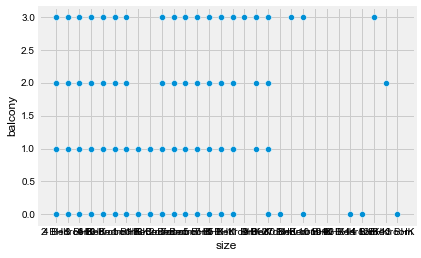

In [127]:
sns.scatterplot(x=df['size'], y=df.balcony)

In [128]:
df[df['balcony'].isna()]

,ID,area_type,availability,location,size,society,total_sqft,bath,balcony,price
6,6,Super built-up Area,18-May,Old Airport Road,4 BHK,Jaades,2732,4.0,NaN,204.00
7,7,Super built-up Area,Ready To Move,Rajaji Nagar,4 BHK,Brway G,3300,4.0,NaN,600.00
9,9,Plot Area,Ready To Move,Gandhi Bazar,6 Bedroom,NaN,1020,6.0,NaN,370.00
34,34,Built-up Area,Ready To Move,Kasturi Nagar,3 BHK,Kantsce,1925,3.0,NaN,125.00
40,40,Built-up Area,Ready To Move,Murugeshpalya,2 BHK,Gentson,1296,2.0,NaN,81.00
...,...,...,...,...,...,...,...,...,...,...
10560,10560,Built-up Area,Ready To Move,HSR Layout,5 Bedroom,NaN,4200,5.0,NaN,245.00
10561,10561,Super built-up Area,Ready To Move,Thubarahalli,3 BHK,Asnts a,1540,3.0,NaN,90.00
10593,10593,Built-up Area,Ready To Move,Marathahalli,4 Bedroom,Vemes H,3090,4.0,NaN,350.00
10634,10634,Plot Area,Immediate Possession,Rajankunte,NaN,NaN,1575,NaN,NaN,31.11


In [129]:
# Dropping the ID column for its redundancy
# Getting rid of society to avoid imputing huge amount of null values
# Availability doesnt much determine the price of a house
df.drop(columns=["ID", "availability", "society"], axis=1, inplace=True)

In [130]:
# Removing only the rows where size is NaN
df = df.dropna(axis=0, subset=['size'])
df.isna().sum()

area_type       0
location        1
size            0
total_sqft      0
bath           51
balcony       490
price           0
dtype: int64

In [131]:
get_room_count = lambda x: int(str(x).split()[0]) if isinstance(x,str) else x

In [132]:
df['size']=df['size'].apply(get_room_count)
df.head()

,area_type,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,Electronic City Phase II,2,1056,2.0,1.0,39.07
1,Plot Area,Chikka Tirupathi,4,2600,5.0,3.0,120.00
2,Built-up Area,Uttarahalli,3,1440,2.0,3.0,62.00
3,Super built-up Area,Lingadheeranahalli,3,1521,3.0,1.0,95.00
4,Super built-up Area,Kothanur,2,1200,2.0,1.0,51.00


In [133]:
from scipy import stats

In [134]:
# Replacing all the NaN values in balcony witht the median of the subgroup based on number of rooms
balcony_df = pd.DataFrame(df.groupby('size')['balcony'].median())

for index, row in df.iterrows():
    if df.loc[index, 'balcony'] == np.NaN:
        df.loc[index, 'balcony'] = balcony_df.loc[df.loc[index,'size']]

df.head()

,area_type,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,Electronic City Phase II,2,1056,2.0,1.0,39.07
1,Plot Area,Chikka Tirupathi,4,2600,5.0,3.0,120.00
2,Built-up Area,Uttarahalli,3,1440,2.0,3.0,62.00
3,Super built-up Area,Lingadheeranahalli,3,1521,3.0,1.0,95.00
4,Super built-up Area,Kothanur,2,1200,2.0,1.0,51.00


In [135]:
df.isna().sum()

area_type       0
location        1
size            0
total_sqft      0
bath           51
balcony       490
price           0
dtype: int64

In [136]:
df.dropna(inplace=True)
df.isna().sum()

area_type     0
location      0
size          0
total_sqft    0
bath          0
balcony       0
price         0
dtype: int64

In [137]:
df.shape

(10151, 7)

In [138]:
df.head()

,area_type,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,Electronic City Phase II,2,1056,2.0,1.0,39.07
1,Plot Area,Chikka Tirupathi,4,2600,5.0,3.0,120.00
2,Built-up Area,Uttarahalli,3,1440,2.0,3.0,62.00
3,Super built-up Area,Lingadheeranahalli,3,1521,3.0,1.0,95.00
4,Super built-up Area,Kothanur,2,1200,2.0,1.0,51.00


In [139]:
df['size'].value_counts()

2     4388
3     3698
4      987
1      530
5      237
6      153
7       65
8       53
9       31
11       3
10       1
27       1
43       1
12       1
13       1
14       1
Name: size, dtype: int64

In [140]:
# Finding all the rows in total_sqft which contain different units
df['total_sqft_is_alphanumeric'] = list(map(lambda x: re.search(r'[a-zA-Z]',x) != None, df['total_sqft']))
df.loc[df['total_sqft_is_alphanumeric']==True].head()

,area_type,location,size,total_sqft,bath,balcony,price,total_sqft_is_alphanumeric
410,Super built-up Area,Kengeri,1,34.46Sq. Meter,1.0,0.0,18.5,True
775,Built-up Area,Basavanagara,1,1000Sq. Meter,2.0,1.0,93.0,True
1019,Plot Area,Marathi Layout,1,5.31Acres,1.0,0.0,110.0,True
1086,Plot Area,Narasapura,2,30Acres,2.0,2.0,29.5,True
1400,Super built-up Area,Chamrajpet,9,716Sq. Meter,9.0,1.0,296.0,True


We can see that there are multiple units which are used here:
SqMeter/Acres/SqYards/Grounds/Cents/Guntha/Perch

Using calculators from https://housing.com/calculators/ground-to-square-feet
* 1 Ground =  2400.352024 sq.ft
* 1 Perch = 272.25 sq.ft
* 1 acre = 43560.00001 sq.ft
* 1 Guntha = 1089 sq.ft
* 1 sq.yards = 9.000000878 sq.ft
* 1 sq.meters = 10.76391042 sq.ft
* 1 Cents = 435.56 sq.ft

In [141]:
def return_in_sq_ft(value, units):
    units = units.lower()
    value=float(value)
    if units=="grounds":
        return value*2400.352024
    elif units=="perch":
        return value*272.25
    elif units=="acres":
        return value*43560.00001
    elif units=="guntha":
        return value*1089
    elif units=="sq.yards":
        return value*9.000000878
    elif units=="sq.meter":
        return value*10.76391042
    elif units=="cents":
        return value*435.56
    else:
        print(f"{units} not FOUND")

def units_in_sq_ft(value):
    if re.search(r'[a-zA-Z]',value) != None:
        
        s_arr = re.findall(r'\d+[.]?\d*|[A-Za-z.]+', value)
        return return_in_sq_ft(s_arr[0], "".join(s_arr[1:]))
    elif value.find("-")!=-1:
        return (float(value.split("-")[0])+float(value.split("-")[1]))/2
    else:
        return float(value)

df["total_sqft"] = df["total_sqft"].apply(units_in_sq_ft)

In [142]:
df.drop(columns=["total_sqft_is_alphanumeric"], inplace=True)

### Adding per square-feet price

In [143]:
df['price_per_square_ft'] = (df['price']*1000000)/df['total_sqft']
df.head()

,area_type,location,size,total_sqft,bath,balcony,price,price_per_square_ft
0,Super built-up Area,Electronic City Phase II,2,1056.0,2.0,1.0,39.07,36998.106061
1,Plot Area,Chikka Tirupathi,4,2600.0,5.0,3.0,120.00,46153.846154
2,Built-up Area,Uttarahalli,3,1440.0,2.0,3.0,62.00,43055.555556
3,Super built-up Area,Lingadheeranahalli,3,1521.0,3.0,1.0,95.00,62458.908613
4,Super built-up Area,Kothanur,2,1200.0,2.0,1.0,51.00,42500.000000


### Finding all the unique Locations

In [144]:
# Removing all the rows where the room-size are lesser that even 300 sq.ft
df_1 = df[~(df['total_sqft']/df['size'] < 300)]
df_1.head()

,area_type,location,size,total_sqft,bath,balcony,price,price_per_square_ft
0,Super built-up Area,Electronic City Phase II,2,1056.0,2.0,1.0,39.07,36998.106061
1,Plot Area,Chikka Tirupathi,4,2600.0,5.0,3.0,120.00,46153.846154
2,Built-up Area,Uttarahalli,3,1440.0,2.0,3.0,62.00,43055.555556
3,Super built-up Area,Lingadheeranahalli,3,1521.0,3.0,1.0,95.00,62458.908613
4,Super built-up Area,Kothanur,2,1200.0,2.0,1.0,51.00,42500.000000


In [145]:
df_1.shape

(9618, 8)

In [146]:
# Erasing the outliers from each group of locations
def remove_pps_outliers(df):
    df_out=pd.DataFrame()
    for key,subdf in df.groupby('location'):
        m=np.mean(subdf.price_per_square_ft)
        st=np.std(subdf.price_per_square_ft)
        reduced_df=subdf[(subdf.price_per_square_ft>(m-1.5*st))& (subdf.price_per_square_ft<(m+1.5*st))]
        df_out=pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df_2=remove_pps_outliers(df_1)
df_2.shape

(8400, 8)

Text(0, 0.5, 'Count')

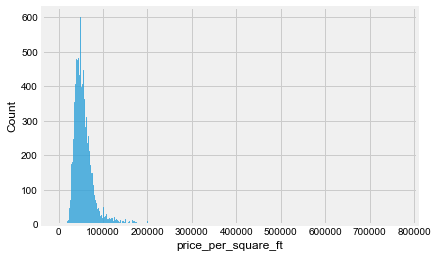

In [147]:
sns.histplot(df_2['price_per_square_ft'])
plt.ylabel('Count')

Text(0, 0.5, 'Count')

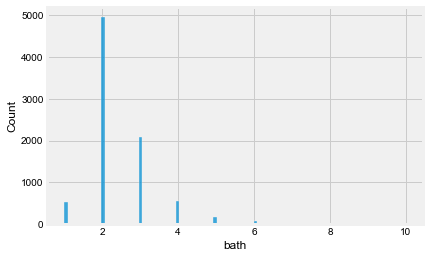

In [148]:
sns.histplot(df_2['bath'])
plt.ylabel('Count')

In [149]:
df_2.head()

,area_type,location,size,total_sqft,bath,balcony,price,price_per_square_ft
0,Super built-up Area,Devarabeesana Halli,3,1672.0,3.0,2.0,150.0,89712.918660
1,Built-up Area,Devarabeesana Halli,3,1750.0,3.0,3.0,149.0,85142.857143
2,Super built-up Area,Devarabeesana Halli,3,1670.0,3.0,2.0,160.0,95808.383234
3,Super built-up Area,Devarabeesana Halli,3,1750.0,3.0,2.0,150.0,85714.285714
4,Super built-up Area,Devarachikkanahalli,3,1250.0,2.0,3.0,44.0,35200.000000


## CHECKING FOR OUTLIERS

<AxesSubplot:xlabel='price'>

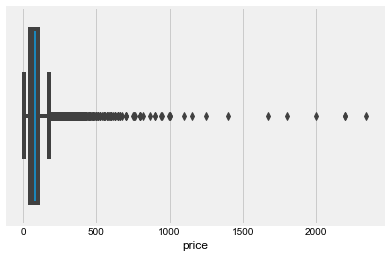

In [150]:
# First checking the target column
sns.boxplot(df_2['price'])

We are keeping the outliers for price, as we might be needed to predict such cases in Test Data

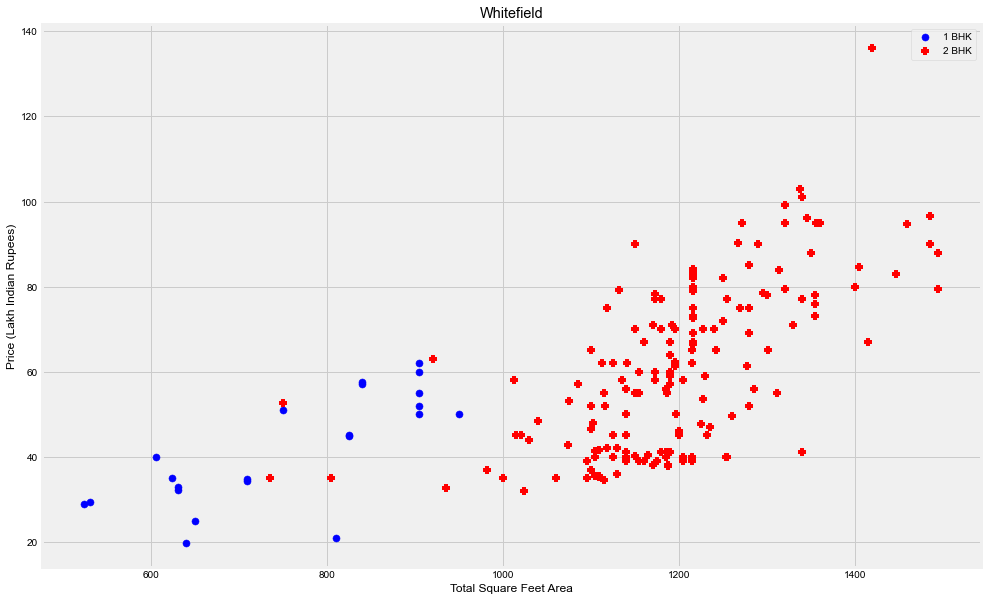

In [151]:
def plot_multiple_size_with_price(size_1, size_2, location, df):
    bhk_first = df[(df['location']==location) & (df['size']==size_1)]
    bhk_second = df[(df['location']==location) & (df['size']==size_2)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk_first.total_sqft,bhk_first.price,color='blue',label=str(size_1)+" BHK", s=50)
    plt.scatter(bhk_second.total_sqft,bhk_second.price,marker='+',color='red',label=str(size_2)+" BHK", s=50)
    
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()

plot_multiple_size_with_price(1,2, "Whitefield", df_2)

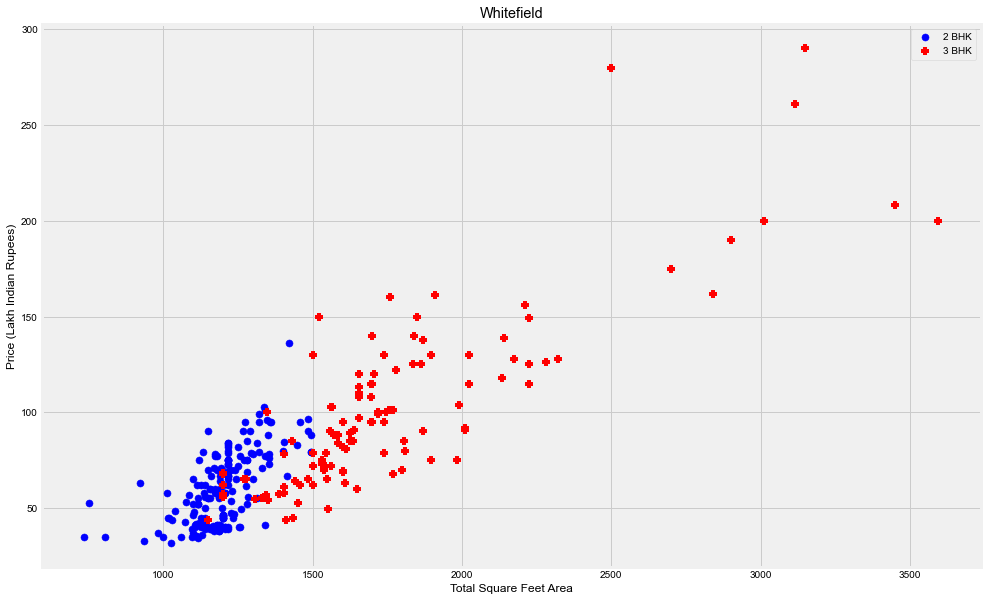

In [152]:
plot_multiple_size_with_price(2,3, "Whitefield", df_2)

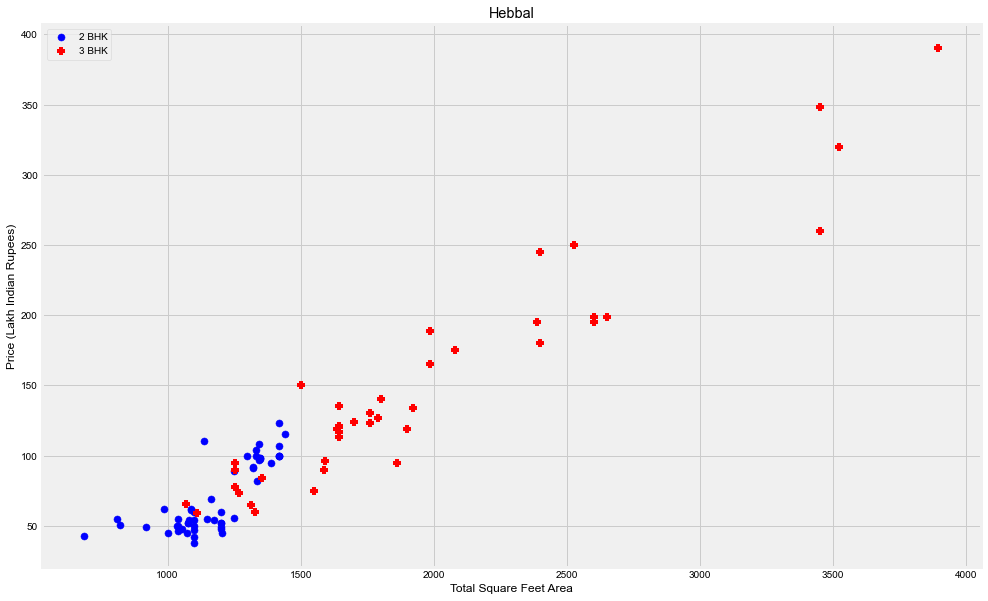

In [153]:
plot_multiple_size_with_price(2,3, "Hebbal", df_2)

In a location, when the square feet increases as well as the number of rooms increase, still certain houses with lower space and room number are priced higher than larger houses. Those rows need to be removed. We will find the mean price of a house of a particular size. And if the per square foot rate of the house is less than mean of smaller size house, then we will get rid of it.

In [154]:
def remove_irregularly_priced_houses(df):
    exclusion_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for size, size_df in location_df.groupby('size'):
            bhk_stats[size] = {
                'mean': np.mean(size_df.price_per_square_ft),
                'std': np.std(size_df.price_per_square_ft),
                'count': size_df.shape[0]
            }
        for size, size_df in location_df.groupby('size'):
            stats = bhk_stats.get(size-1)
            if stats and stats['count'] > 5:
                exclusion_indices = np.append(exclusion_indices, size_df[size_df.price_per_square_ft<(stats['mean'])].index.values)
    return df.drop(exclusion_indices, axis='index')

df_3 = remove_irregularly_priced_houses(df_2)
df_3.head()

,area_type,location,size,total_sqft,bath,balcony,price,price_per_square_ft
0,Super built-up Area,Devarabeesana Halli,3,1672.0,3.0,2.0,150.0,89712.918660
1,Built-up Area,Devarabeesana Halli,3,1750.0,3.0,3.0,149.0,85142.857143
2,Super built-up Area,Devarabeesana Halli,3,1670.0,3.0,2.0,160.0,95808.383234
3,Super built-up Area,Devarabeesana Halli,3,1750.0,3.0,2.0,150.0,85714.285714
5,Super built-up Area,Devarachikkanahalli,2,1250.0,2.0,2.0,40.0,32000.000000


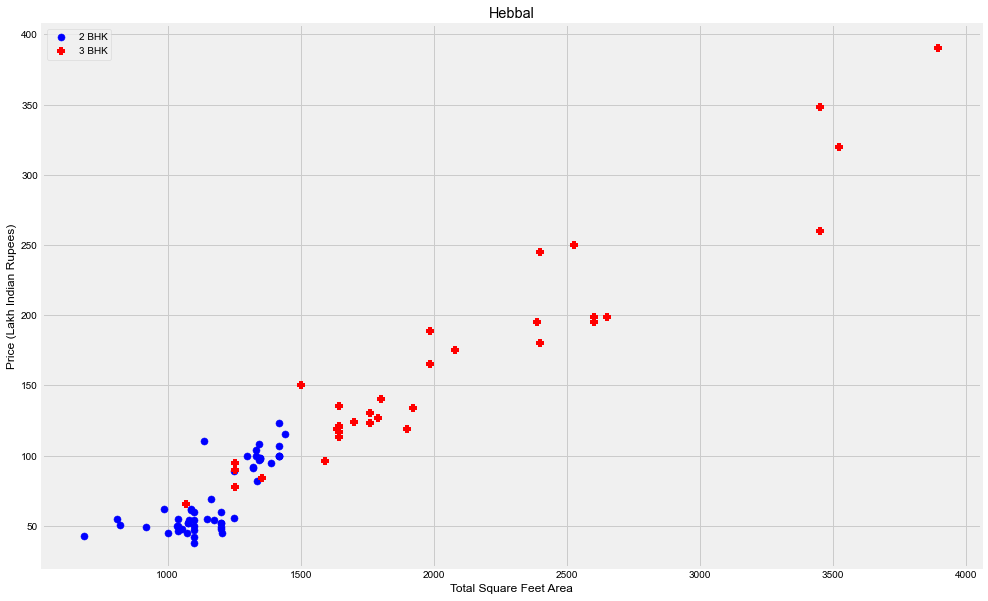

In [155]:
plot_multiple_size_with_price(2,3, "Hebbal", df_3)

We can see that the number of 3 BHKs with lesser price-per-square-feet as compared to 2 BHK are removed.

## Doing PREPROCESSING

In [156]:
from sklearn import preprocessing

df_2_num = df_2.select_dtypes(include=np.number)
# Dropping the future target column from Scaling
df_2_num.drop(columns=['price'], inplace=True)
min_max_scaler = preprocessing.MinMaxScaler()
df_2_num_scaled = min_max_scaler.fit_transform(df_2_num.values)
scaled_df = pd.DataFrame(df_2_num_scaled, columns=df_2_num.columns)
scaled_df.head()

,size,total_sqft,bath,balcony,price_per_square_ft
0,0.25,0.002101,0.222222,0.666667,0.116245
1,0.25,0.002220,0.222222,1.000000,0.110302
2,0.25,0.002098,0.222222,0.666667,0.124173
3,0.25,0.002220,0.222222,0.666667,0.111045
4,0.25,0.001455,0.111111,1.000000,0.045348


In [157]:
df_2_normalized = pd.concat([df_2.select_dtypes(exclude=np.number), scaled_df, df_2['price']], axis=1)
df_2_normalized.head()

,area_type,location,size,total_sqft,bath,balcony,price_per_square_ft,price
0,Super built-up Area,Devarabeesana Halli,0.25,0.002101,0.222222,0.666667,0.116245,150.0
1,Built-up Area,Devarabeesana Halli,0.25,0.002220,0.222222,1.000000,0.110302,149.0
2,Super built-up Area,Devarabeesana Halli,0.25,0.002098,0.222222,0.666667,0.124173,160.0
3,Super built-up Area,Devarabeesana Halli,0.25,0.002220,0.222222,0.666667,0.111045,150.0
4,Super built-up Area,Devarachikkanahalli,0.25,0.001455,0.111111,1.000000,0.045348,44.0


In [158]:
df_2['location'] = df_2['location'].apply(lambda x: x.lower().strip().replace('  ', ' '))
df_2_normalized['location'] = df_2_normalized['location'].apply(lambda x: x.lower().strip().replace('  ', ' '))
df_test['location'] = df_test['location'].apply(lambda x: x.lower().strip().replace('  ', ' '))
df_dist['location'] = df_dist['location'].apply(lambda x: x.lower().strip().replace('  ', ' '))

set_locations_train_data = set(df_2['location'].unique())
set_locations_test_data = set(df_test['location'].unique())
set_location_dist = set(df_dist['location'].unique())
set_location_in_both_train_test_data = set_locations_test_data.intersection(set_locations_train_data)

In [159]:
print(len(set_locations_train_data))

685


In [160]:
print(len(set_locations_test_data))

669


In [161]:
print(len(set_location_in_both_train_test_data))

474


In order to have the same number of columns in both train and test data, we need to set any location which is not present in both train and test data as other

In [162]:
# Setting the location which are rare as other
df_2_normalized['location'] = df_2_normalized['location'].apply(lambda x: x if x in set_location_in_both_train_test_data else 'other')

print(f"{len(df_2_normalized['location'].unique())}")

475


In [163]:
df_2_normalized.loc[df_2_normalized['location']=="other"]

,area_type,location,size,total_sqft,bath,balcony,price_per_square_ft,price
26,Plot Area,other,0.250,0.003215,0.111111,0.000000,0.259680,480.00
27,Built-up Area,other,0.375,0.004777,0.222222,0.666667,0.155483,410.00
28,Super built-up Area,other,0.250,0.001899,0.222222,0.666667,0.071352,85.00
29,Built-up Area,other,0.375,0.002297,0.444444,0.333333,0.180202,250.00
67,Super built-up Area,other,0.250,0.002171,0.222222,1.000000,0.168384,223.00
...,...,...,...,...,...,...,...,...
8395,Super built-up Area,other,0.250,0.002266,0.222222,0.333333,0.061549,84.83
8396,Super built-up Area,other,0.125,0.001565,0.111111,0.333333,0.060553,61.99
8397,Plot Area,other,0.125,0.000888,0.111111,0.333333,0.070508,48.00
8398,Plot Area,other,0.125,0.001072,0.111111,0.333333,0.071099,55.00


In [164]:
df_rent["location"] = df_rent["location"].apply(lambda x: x.lower().strip().replace('  ', ' '))
len(set(df_rent["location"].unique()).intersection(set_location_in_both_train_test_data))

88

Since columns whose locations are present in test-data and train data and in rent data is so less... we would never be able to use this table for analysis.

In [165]:
df_dist["location"] = df_dist["location"].apply(lambda x: x.lower().strip().replace('  ', ' '))
len(set(df_dist["location"].unique()).intersection(set_location_in_both_train_test_data))

421

In [166]:
# Setting the location distance from CITY Centre as well in df_2
df_3 = df_2_normalized.copy()

In [167]:
df_3.head()

,area_type,location,size,total_sqft,bath,balcony,price_per_square_ft,price
0,Super built-up Area,devarabeesana halli,0.25,0.002101,0.222222,0.666667,0.116245,150.0
1,Built-up Area,devarabeesana halli,0.25,0.002220,0.222222,1.000000,0.110302,149.0
2,Super built-up Area,devarabeesana halli,0.25,0.002098,0.222222,0.666667,0.124173,160.0
3,Super built-up Area,devarabeesana halli,0.25,0.002220,0.222222,0.666667,0.111045,150.0
4,Super built-up Area,devarachikkanahalli,0.25,0.001455,0.111111,1.000000,0.045348,44.0


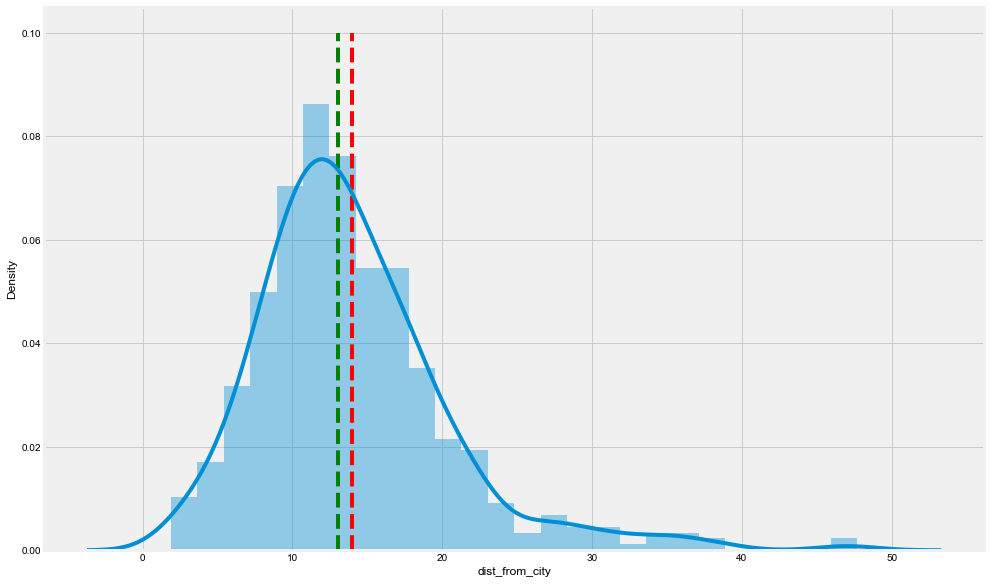

In [168]:
sns.distplot(df_dist['dist_from_city'], kde=True)
plt.vlines(x=df_dist['dist_from_city'].mean(), ymin=0, ymax=0.1, colors='r', linestyles='dashed')
plt.vlines(x=df_dist['dist_from_city'].median(), ymin=0, ymax=0.1, colors='g', linestyles='dashed')

In [169]:
def get_dist(location):
    if location in df_dist['location'].unique():
        return df_dist.loc[df_dist['location'] == location]['dist_from_city'].values[0]
    else:
        return df_dist['dist_from_city'].median()

df_3['dist'] = df_3['location'].apply(get_dist)
df_3.head()

,area_type,location,size,total_sqft,bath,balcony,price_per_square_ft,price,dist
0,Super built-up Area,devarabeesana halli,0.25,0.002101,0.222222,0.666667,0.116245,150.0,14.4
1,Built-up Area,devarabeesana halli,0.25,0.002220,0.222222,1.000000,0.110302,149.0,14.4
2,Super built-up Area,devarabeesana halli,0.25,0.002098,0.222222,0.666667,0.124173,160.0,14.4
3,Super built-up Area,devarabeesana halli,0.25,0.002220,0.222222,0.666667,0.111045,150.0,14.4
4,Super built-up Area,devarachikkanahalli,0.25,0.001455,0.111111,1.000000,0.045348,44.0,12.0


In [170]:
df_3.isna().sum()

area_type              0
location               0
size                   0
total_sqft             0
bath                   0
balcony                0
price_per_square_ft    0
price                  0
dist                   0
dtype: int64

In [171]:
df_3.dropna()

,area_type,location,size,total_sqft,bath,balcony,price_per_square_ft,price,dist
0,Super built-up Area,devarabeesana halli,0.250,0.002101,0.222222,0.666667,0.116245,150.00,14.40
1,Built-up Area,devarabeesana halli,0.250,0.002220,0.222222,1.000000,0.110302,149.00,14.40
2,Super built-up Area,devarabeesana halli,0.250,0.002098,0.222222,0.666667,0.124173,160.00,14.40
3,Super built-up Area,devarabeesana halli,0.250,0.002220,0.222222,0.666667,0.111045,150.00,14.40
4,Super built-up Area,devarachikkanahalli,0.250,0.001455,0.111111,1.000000,0.045348,44.00,12.00
...,...,...,...,...,...,...,...,...,...
8395,Super built-up Area,other,0.250,0.002266,0.222222,0.333333,0.061549,84.83,13.05
8396,Super built-up Area,other,0.125,0.001565,0.111111,0.333333,0.060553,61.99,13.05
8397,Plot Area,other,0.125,0.000888,0.111111,0.333333,0.070508,48.00,13.05
8398,Plot Area,other,0.125,0.001072,0.111111,0.333333,0.071099,55.00,13.05


In [172]:
def min_max_scale(x, min_val, max_val):
    return (x - min_val)/(max_val - min_val)


In [173]:
# Doing min-max scaling on the dist column which is remaining
min_val = df_3['dist'].min()
max_val = df_3['dist'].max()


df_3['dist'] = df_3['dist'].apply(min_max_scale, args=(min_val,max_val))
df_3.head()

,area_type,location,size,total_sqft,bath,balcony,price_per_square_ft,price,dist
0,Super built-up Area,devarabeesana halli,0.25,0.002101,0.222222,0.666667,0.116245,150.0,0.272926
1,Built-up Area,devarabeesana halli,0.25,0.002220,0.222222,1.000000,0.110302,149.0,0.272926
2,Super built-up Area,devarabeesana halli,0.25,0.002098,0.222222,0.666667,0.124173,160.0,0.272926
3,Super built-up Area,devarabeesana halli,0.25,0.002220,0.222222,0.666667,0.111045,150.0,0.272926
4,Super built-up Area,devarachikkanahalli,0.25,0.001455,0.111111,1.000000,0.045348,44.0,0.220524


In [174]:
df_3.isna().sum()

area_type              0
location               0
size                   0
total_sqft             0
bath                   0
balcony                0
price_per_square_ft    0
price                  0
dist                   0
dtype: int64

In [175]:
df_3.dropna(inplace=True)

In [176]:
df_3.isna().sum()

area_type              0
location               0
size                   0
total_sqft             0
bath                   0
balcony                0
price_per_square_ft    0
price                  0
dist                   0
dtype: int64

In [177]:
# Dummy encoding for location
dummies = pd.get_dummies(data=df_3, columns=['location','area_type'])
dummies.head()

,size,total_sqft,bath,balcony,price_per_square_ft,price,dist,location_1st block hbr layout,location_1st block hrbr layout,location_1st block jayanagar,...,location_yelahanka,location_yelahanka new town,location_yelenahalli,location_yemlur,location_yeshwanthpur,location_yeshwanthpur industrial suburb,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area
0,0.25,0.002101,0.222222,0.666667,0.116245,150.0,0.272926,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.25,0.002220,0.222222,1.000000,0.110302,149.0,0.272926,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0.25,0.002098,0.222222,0.666667,0.124173,160.0,0.272926,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.25,0.002220,0.222222,0.666667,0.111045,150.0,0.272926,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.25,0.001455,0.111111,1.000000,0.045348,44.0,0.220524,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [178]:
df_4 = dummies.copy()
df_4.head()

,size,total_sqft,bath,balcony,price_per_square_ft,price,dist,location_1st block hbr layout,location_1st block hrbr layout,location_1st block jayanagar,...,location_yelahanka,location_yelahanka new town,location_yelenahalli,location_yemlur,location_yeshwanthpur,location_yeshwanthpur industrial suburb,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area
0,0.25,0.002101,0.222222,0.666667,0.116245,150.0,0.272926,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.25,0.002220,0.222222,1.000000,0.110302,149.0,0.272926,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0.25,0.002098,0.222222,0.666667,0.124173,160.0,0.272926,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.25,0.002220,0.222222,0.666667,0.111045,150.0,0.272926,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.25,0.001455,0.111111,1.000000,0.045348,44.0,0.220524,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [179]:
X=df_4.drop('price', axis='columns')
X.head()

,size,total_sqft,bath,balcony,price_per_square_ft,dist,location_1st block hbr layout,location_1st block hrbr layout,location_1st block jayanagar,location_1st block koramangala,...,location_yelahanka,location_yelahanka new town,location_yelenahalli,location_yemlur,location_yeshwanthpur,location_yeshwanthpur industrial suburb,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area
0,0.25,0.002101,0.222222,0.666667,0.116245,0.272926,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.25,0.002220,0.222222,1.000000,0.110302,0.272926,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0.25,0.002098,0.222222,0.666667,0.124173,0.272926,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.25,0.002220,0.222222,0.666667,0.111045,0.272926,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.25,0.001455,0.111111,1.000000,0.045348,0.220524,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [180]:
y = df_4['price']

In [181]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

model_1=LinearRegression()
model_1.fit(X_train,y_train)
model_1.score(X_test,y_test)

-9.670449424436589e+20

In [182]:
model_1.predict(X)

array([156.5 , 149.  , 169.  , ...,  70.25,  71.25,  89.  ])

In [183]:
y

0       150.00
1       149.00
2       160.00
3       150.00
4        44.00
         ...  
8395     84.83
8396     61.99
8397     48.00
8398     55.00
8399     78.00
Name: price, Length: 8400, dtype: float64

In [184]:
rmse(model_1.predict(X), y)

1267747145137.7703

#### Dropping the price_per_square_feet column

In [185]:
X_1 = X.drop(columns=["price_per_square_ft"])
X_1.shape

(8400, 484)

In [186]:
X_train,X_test,y_train,y_test=train_test_split(X_1,y,test_size=0.2)

model_3=LinearRegression()
model_3.fit(X_train,y_train)
model_3.score(X_test,y_test)

-2.5742994444161375e+20

In [187]:
X_1.head()

,size,total_sqft,bath,balcony,dist,location_1st block hbr layout,location_1st block hrbr layout,location_1st block jayanagar,location_1st block koramangala,location_1st phase jp nagar,...,location_yelahanka,location_yelahanka new town,location_yelenahalli,location_yemlur,location_yeshwanthpur,location_yeshwanthpur industrial suburb,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area
0,0.25,0.002101,0.222222,0.666667,0.272926,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.25,0.002220,0.222222,1.000000,0.272926,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0.25,0.002098,0.222222,0.666667,0.272926,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.25,0.002220,0.222222,0.666667,0.272926,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.25,0.001455,0.111111,1.000000,0.220524,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [188]:


def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        y_pred=gs.predict(X)
        gs_rmse = rmse(y,y_pred)
        scores.append({
            'model': algo_name,
            'shape': X.shape,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_,
            'rmse': gs_rmse
        })

    return pd.DataFrame(scores,columns=['model','shape', 'best_score','best_params','rmse'])

find_best_model_using_gridsearchcv(X_1,y)


,model,shape,best_score,best_params,rmse
0,linear_regression,"(8400, 484)",-3.003872e+23,{'normalize': False},66.902768
1,lasso,"(8400, 484)",3.579609e-01,"{'alpha': 1, 'selection': 'random'}",83.009770
2,decision_tree,"(8400, 484)",5.944228e-01,"{'criterion': 'mse', 'splitter': 'best'}",4.056354


In [189]:
X_1.shape

(8400, 484)

In [190]:
res_df = pd.DataFrame(columns=['model','best_score','best_params','rmse'])
# Creating the best model separately

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
gs =  GridSearchCV(
    DecisionTreeRegressor(), 
    {
        'criterion' : ['mse','friedman_mse'],
        'splitter': ['best','random']
    },
    cv=cv, 
    return_train_score=False
)
gs.fit(X_1,y)

y_pred=gs.predict(X_1)
gs_rmse = rmse(y,y_pred)
res_df.append({
    "model": "DecisionTreeRegressor",
    "best_score": gs.best_score_,
    "best_params": gs.best_params_,
    "rmse": gs_rmse
}, ignore_index=True)

,model,best_score,best_params,rmse
0,DecisionTreeRegressor,0.596394,"{'criterion': 'friedman_mse', 'splitter': 'best'}",4.056354


In [191]:
# Trying Grid Search CV with ElasticNet
hyp_param = {'alpha':[0,0.001, 0.01, 0.1,1,2], 'l1_ratio':[0.71, 0.75, 0.79, 0.8, 0.85, 0.999, 1]}
enet = ElasticNet(normalize=True)
hyper_model = GridSearchCV(estimator=enet, param_grid=hyp_param, cv=5, scoring='r2')

enet_model = hyper_model.fit(X_1, y)
print(f"Best Hyper Parameter: {enet_model.best_params_}")
print(f"Best Score: {enet_model.best_score_}")

Best Hyper Parameter: {'alpha': 0.1, 'l1_ratio': 0.85}
Best Score: 0.007097702858139998


In [192]:
enet_rmse = rmse(enet_model.predict(X_1),y)
enet_rmse

101.63724884113365

In [193]:
from sklearn.ensemble import RandomForestRegressor

x_train,x_test,y_train,y_test=train_test_split(X_1,y, test_size=0.25)
RFC = RandomForestRegressor(n_estimators=75, n_jobs=-1, oob_score=True, random_state=10)
RFC.fit(x_train,y_train)
y_test_pred = RFC.predict(x_test)
rmse(y_test, y_test_pred)

56.64064785310852

In [194]:
from sklearn.model_selection import GridSearchCV

x=X_1

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.05,random_state=10)

param={'max_depth':[5,10,15,20,30],'min_samples_leaf':[10,15,20,50,100]}

gs_rfc=GridSearchCV(estimator=RFC,param_grid=param,cv=4,n_jobs=-1,scoring='r2')

gs_rfc.fit(x_train,y_train)

gs_rfc.best_estimator_
gs_best=gs_rfc.best_estimator_

gs_best.fit(x_train,y_train)

train_pred=gs_best.predict(x_train)

test_pred=gs_best.predict(x_test)


print('RMSE for train:',np.sqrt(mean_squared_error(y_train,train_pred)))
print('RMSE for test:',np.sqrt(mean_squared_error(y_test,test_pred)))


print('r2_score for train:',r2_score(y_train,train_pred))
print('r2_score for test:',r2_score(y_test,test_pred))

RMSE for train: 53.70196364701319
RMSE for test: 48.58022670087503
r2_score for train: 0.7271695574339176
r2_score for test: 0.7011140256358208


## PROCESSING THE TEST-DATA

In [195]:
df_test.head()

,ID,area_type,availability,location,size,society,total_sqft,bath,balcony
0,0,Super built-up Area,Ready To Move,chamrajpet,2 BHK,NaN,650,1.0,1.0
1,1,Super built-up Area,Ready To Move,7th phase jp nagar,3 BHK,SrncyRe,1370,2.0,1.0
2,2,Super built-up Area,Ready To Move,whitefield,3 BHK,AjhalNa,1725,3.0,2.0
3,3,Built-up Area,Ready To Move,jalahalli,2 BHK,NaN,1000,2.0,0.0
4,4,Plot Area,Ready To Move,tc palaya,1 Bedroom,NaN,1350,1.0,0.0


In [196]:
df_test.columns

Index(['ID', 'area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony'],
      dtype='object')

In [197]:
df_test_1 = df_test.drop(columns=["ID", "availability", "society"])
df_test_1.isna().sum()

area_type       0
location        0
size            2
total_sqft      0
bath            8
balcony       105
dtype: int64

In [198]:
df_test_1['size']=df_test_1['size'].apply(get_room_count)

In [199]:
df_test_1.head()

,area_type,location,size,total_sqft,bath,balcony
0,Super built-up Area,chamrajpet,2.0,650,1.0,1.0
1,Super built-up Area,7th phase jp nagar,3.0,1370,2.0,1.0
2,Super built-up Area,whitefield,3.0,1725,3.0,2.0
3,Built-up Area,jalahalli,2.0,1000,2.0,0.0
4,Plot Area,tc palaya,1.0,1350,1.0,0.0


In [200]:
df_test_1["total_sqft"] = df_test_1["total_sqft"].apply(units_in_sq_ft)

In [201]:
df_test_1['size'].fillna(df_test_1['total_sqft']//300, inplace=True)

In [202]:
df_test_1['size']=df_test_1['size'].apply(get_room_count)
df_test_1.head()

,area_type,location,size,total_sqft,bath,balcony
0,Super built-up Area,chamrajpet,2.0,650.0,1.0,1.0
1,Super built-up Area,7th phase jp nagar,3.0,1370.0,2.0,1.0
2,Super built-up Area,whitefield,3.0,1725.0,3.0,2.0
3,Built-up Area,jalahalli,2.0,1000.0,2.0,0.0
4,Plot Area,tc palaya,1.0,1350.0,1.0,0.0


In [203]:
for index, row in df_test_1.iterrows():
    if np.isnan(df_test_1.loc[index, 'balcony']):
        if df_test_1.loc[index,'size'] in balcony_df.index:
            df_test_1.loc[index, 'balcony'] = balcony_df.loc[df_test_1.loc[index,'size'], 'balcony']
        else:
            df_test_1.loc[index, 'balcony'] = 0



In [204]:
df_test_1.isna().sum()

area_type     0
location      0
size          0
total_sqft    0
bath          8
balcony       0
dtype: int64

<AxesSubplot:xlabel='size', ylabel='bath'>

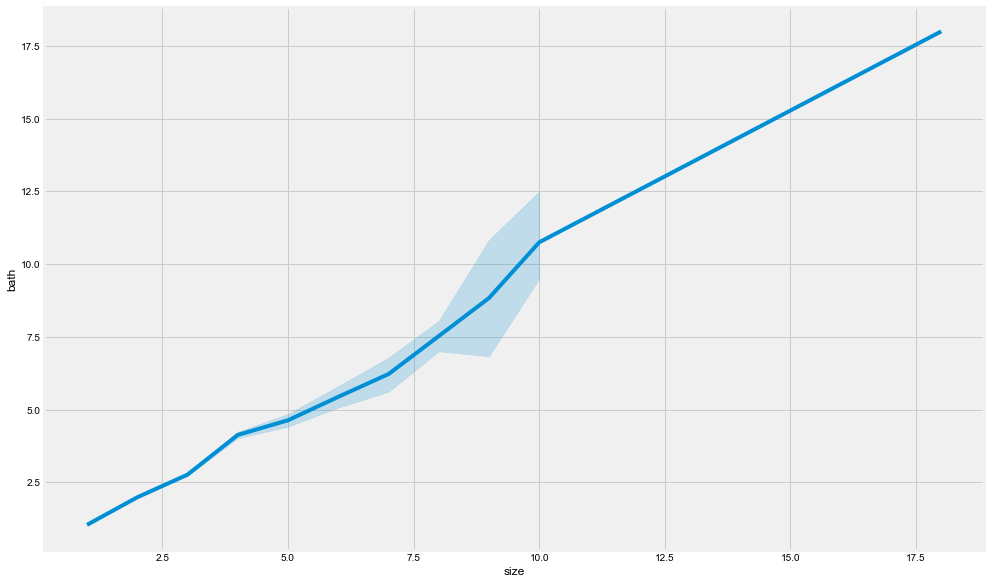

In [205]:
sns.lineplot(x=df_test_1['size'], y=df_test_1['bath'])

In [206]:
df_test_1[df_test_1['bath'].isna()]

,area_type,location,size,total_sqft,bath,balcony
70,Super built-up Area,sarjapur road,3.0,1773.5,NaN,2.0
363,Plot Area,yelahanka,5.0,1500.0,NaN,2.0
641,Super built-up Area,hennur,4.0,3517.0,NaN,2.0
840,Super built-up Area,kanakpura road,1.0,525.0,NaN,1.0
913,Plot Area,hosur road,4.0,1350.0,NaN,2.0
2112,Built-up Area,bettahalsoor,5.0,3210.0,NaN,2.0
2205,Super built-up Area,kr puram,4.0,2283.0,NaN,2.0
2584,Super built-up Area,devanahalli,1.0,1075.0,NaN,1.0


As per the line-plot, the number of baths is equal to number of rooms.

In [207]:
df_test_1['bath'].fillna(df_test_1['size'], inplace=True)

In [208]:
df_test_1.isna().sum()

area_type     0
location      0
size          0
total_sqft    0
bath          0
balcony       0
dtype: int64

In [209]:
df_test_1.head()

,area_type,location,size,total_sqft,bath,balcony
0,Super built-up Area,chamrajpet,2.0,650.0,1.0,1.0
1,Super built-up Area,7th phase jp nagar,3.0,1370.0,2.0,1.0
2,Super built-up Area,whitefield,3.0,1725.0,3.0,2.0
3,Built-up Area,jalahalli,2.0,1000.0,2.0,0.0
4,Plot Area,tc palaya,1.0,1350.0,1.0,0.0


In [210]:
# df_test_1['area_type']=df_test_1['area_type'].map(ordinal_encoding_area_dict)

In [211]:
df_test_1.head()

,area_type,location,size,total_sqft,bath,balcony
0,Super built-up Area,chamrajpet,2.0,650.0,1.0,1.0
1,Super built-up Area,7th phase jp nagar,3.0,1370.0,2.0,1.0
2,Super built-up Area,whitefield,3.0,1725.0,3.0,2.0
3,Built-up Area,jalahalli,2.0,1000.0,2.0,0.0
4,Plot Area,tc palaya,1.0,1350.0,1.0,0.0


In [212]:
df_test_num = df_test_1.select_dtypes(include=np.number)
min_max_scaler = preprocessing.MinMaxScaler()
df_test_num_scaled = min_max_scaler.fit_transform(df_test_num.values)
scaled_test_df = pd.DataFrame(df_test_num_scaled, columns=df_test_num.columns)

In [213]:
scaled_test_df.head()

,size,total_sqft,bath,balcony
0,0.058824,0.002258,0.000000,0.333333
1,0.117647,0.005013,0.058824,0.333333
2,0.117647,0.006372,0.117647,0.666667
3,0.058824,0.003597,0.058824,0.000000
4,0.000000,0.004937,0.000000,0.000000


In [214]:
df_test_normalized = pd.concat([df_test_1.select_dtypes(exclude=np.number), scaled_test_df], axis=1)
df_test_normalized.head()

,area_type,location,size,total_sqft,bath,balcony
0,Super built-up Area,chamrajpet,0.058824,0.002258,0.000000,0.333333
1,Super built-up Area,7th phase jp nagar,0.117647,0.005013,0.058824,0.333333
2,Super built-up Area,whitefield,0.117647,0.006372,0.117647,0.666667
3,Built-up Area,jalahalli,0.058824,0.003597,0.058824,0.000000
4,Plot Area,tc palaya,0.000000,0.004937,0.000000,0.000000


In [215]:
df_test_normalized['location'] = df_test_normalized['location'].apply(lambda x: x if x in set_location_in_both_train_test_data else 'other')

In [216]:
len(df_test_normalized['location'].unique())

475

In [217]:
# Adding dist column
df_test_normalized['dist'] = df_test_normalized['location'].apply(get_dist)


In [218]:
# Doing min-max scaling on the dist column which is remaining
min_val = df_test_normalized['dist'].min()
max_val = df_test_normalized['dist'].max()
df_test_normalized['dist'] = df_test_normalized['dist'].apply(min_max_scale, args=(min_val,max_val))

In [219]:
df_test_normalized.head()

,area_type,location,size,total_sqft,bath,balcony,dist
0,Super built-up Area,chamrajpet,0.058824,0.002258,0.000000,0.333333,0.104803
1,Super built-up Area,7th phase jp nagar,0.117647,0.005013,0.058824,0.333333,0.198690
2,Super built-up Area,whitefield,0.117647,0.006372,0.117647,0.666667,0.336245
3,Built-up Area,jalahalli,0.058824,0.003597,0.058824,0.000000,0.320961
4,Plot Area,tc palaya,0.000000,0.004937,0.000000,0.000000,0.224891


In [220]:
df_test_normalized.isna().sum()

area_type     0
location      0
size          0
total_sqft    0
bath          0
balcony       0
dist          0
dtype: int64

In [221]:
dummies = pd.get_dummies(data=df_test_normalized, columns=['area_type','location'])
dummies.head()

,size,total_sqft,bath,balcony,dist,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,location_1st block hbr layout,...,location_volagerekallahalli,location_whitefield,location_wilson garden,location_yelachenahalli,location_yelahanka,location_yelahanka new town,location_yelenahalli,location_yemlur,location_yeshwanthpur,location_yeshwanthpur industrial suburb
0,0.058824,0.002258,0.000000,0.333333,0.104803,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0.117647,0.005013,0.058824,0.333333,0.198690,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0.117647,0.006372,0.117647,0.666667,0.336245,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,0.058824,0.003597,0.058824,0.000000,0.320961,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.004937,0.000000,0.000000,0.224891,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [222]:
df_test_2 = dummies.copy()
df_test_2.head()

,size,total_sqft,bath,balcony,dist,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area,location_1st block hbr layout,...,location_volagerekallahalli,location_whitefield,location_wilson garden,location_yelachenahalli,location_yelahanka,location_yelahanka new town,location_yelenahalli,location_yemlur,location_yeshwanthpur,location_yeshwanthpur industrial suburb
0,0.058824,0.002258,0.000000,0.333333,0.104803,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0.117647,0.005013,0.058824,0.333333,0.198690,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0.117647,0.006372,0.117647,0.666667,0.336245,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,0.058824,0.003597,0.058824,0.000000,0.320961,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.004937,0.000000,0.000000,0.224891,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [223]:
# df_test_3 = df_test_2.drop(columns=["location"])

In [224]:
df_test_2.shape

(2664, 484)

In [225]:
y_test_pred = gs.predict(df_test_2)
y_test_pred

array([200., 246., 255., ..., 510., 217.,  62.])

In [226]:
df_sol = pd.DataFrame()
df_sol['price'] = y_test_pred
df_sol.index.name='ID'
df_sol.head()

,price
ID,
0,200.0
1,246.0
2,255.0
3,500.0
4,246.0


In [227]:
df_sol.to_csv("sol_gs.csv")

### Using Elastic Regression Model

In [228]:
y_pred_enet = enet_model.predict(df_test_2)
y_pred_enet

array([91.78265631, 92.11538164, 92.28860934, ..., 91.85919203,
       92.74048019, 91.38889546])

In [229]:
df_sol_enet = pd.DataFrame()
df_sol_enet['price'] = y_pred_enet
df_sol_enet.index.name='ID'
df_sol_enet.head()

,price
ID,
0,91.782656
1,92.115382
2,92.288609
3,91.776868
4,91.452403


In [230]:
df_sol_enet.to_csv("sol_enet.csv")

### Using Random Forest

In [231]:
y_pred_RFC = RFC.predict(df_test_2)
df_sol_RFC = pd.DataFrame()
df_sol_RFC['price'] = y_pred_enet
df_sol_RFC.index.name='ID'
df_sol_RFC.to_csv("sol_RFC.csv")

### Using GridSearch CV on Random Forest

In [232]:
y_pred_GS_CV = gs_best.predict(df_test_2)
df_sol_GS_CV = pd.DataFrame()
df_sol_GS_CV['price'] = y_pred_GS_CV
df_sol_GS_CV.index.name='ID'
df_sol_GS_CV.to_csv("sol_GS_CV.csv")